In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.distributions import uniform

import torchvision.transforms as transforms
import torchvision.datasets as datasets

import seaborn as sns
import matplotlib.pyplot as plt

# Exploring batch normalization

### Defining Pytorch dataset and loader

In [30]:
dataset = datasets.MNIST(
    root='../datasets',
    download=True,
    train = True,
    transform=transforms.ToTensor()
)

loader = DataLoader(
    dataset,
    num_workers=4,
    batch_size=512,
    shuffle=True
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Defining custom batch norm module

In [32]:
class CustomBatchNorm(nn.Module):

    def __init__(self, in_size, momentum=0.9, eps = 1e-5):
        super(CustomBatchNorm, self).__init__()

        self.momentum = momentum
        self.insize = in_size
        self.eps = eps

        U = uniform.Uniform(torch.tensor([0.0]), torch.tensor([1.0]))
        self.gamma = nn.Parameter(U.sample(torch.Size([self.insize])).view(self.insize))
        self.beta = nn.Parameter(torch.zeros(self.insize))

        self.register_buffer('running_mean', torch.zeros(self.insize))
        self.register_buffer('running_var', torch.ones(self.insize))

        self.running_mean.zero_()
        self.running_var.fill_(1)


    def forward(self, input):

        X = input

        if len(X.shape)!=2:
            raise ValueError("only support dense layers")

        if self.training:
            mean = torch.mean(X, axis=0)
            variance = torch.mean((X-mean)**2, axis=0)

            self.running_mean = (self.momentum * self.running_mean) + (1.0-self.momentum) * mean
            self.running_var = (self.momentum * self.running_var) + (1.0-self.momentum) * (input.shape[0]/(input.shape[0]-1)*variance)

        else:
            mean = self.running_mean
            variance = self.running_var

        X_hat = (X - mean) * 1.0 /torch.sqrt(variance + self.eps)
        out = self.gamma * X_hat + self.beta


        return out

### Example neural net

In [33]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(28 * 28, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [34]:
class SimpleNetBN(nn.Module):
    def __init__(self):
        super(SimpleNetBN, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(28 * 28, 64),
            CustomBatchNorm(64),
            nn.ReLU(),
            nn.Linear(64, 128),
            CustomBatchNorm(128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Experiment of training with and without Batch Norm

In [35]:
net_without_batch_norm = SimpleNet()

In [36]:
net_with_batch_norm = SimpleNetBN()

In [37]:
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(net_without_batch_norm.parameters(), lr=0.01)
opt_bn = optim.SGD(net_with_batch_norm.parameters(), lr=0.01)

[1,   512] loss: 0.058  loss_bn: 0.058
[1, 20992] loss: 2.299  loss_bn: 2.073
[1, 41472] loss: 2.285  loss_bn: 1.757
[2,   512] loss: 0.057  loss_bn: 0.036
[2, 20992] loss: 2.254  loss_bn: 1.335
[2, 41472] loss: 2.233  loss_bn: 1.169
[3,   512] loss: 0.055  loss_bn: 0.024
[3, 20992] loss: 2.178  loss_bn: 0.947
[3, 41472] loss: 2.133  loss_bn: 0.836
[4,   512] loss: 0.051  loss_bn: 0.019
[4, 20992] loss: 2.017  loss_bn: 0.698
[4, 41472] loss: 1.939  loss_bn: 0.637
[5,   512] loss: 0.045  loss_bn: 0.014
[5, 20992] loss: 1.727  loss_bn: 0.537
[5, 41472] loss: 1.608  loss_bn: 0.507
[6,   512] loss: 0.035  loss_bn: 0.012
[6, 20992] loss: 1.355  loss_bn: 0.445
[6, 41472] loss: 1.234  loss_bn: 0.416
[7,   512] loss: 0.027  loss_bn: 0.011
[7, 20992] loss: 1.039  loss_bn: 0.376
[7, 41472] loss: 0.965  loss_bn: 0.368
[8,   512] loss: 0.022  loss_bn: 0.009
[8, 20992] loss: 0.840  loss_bn: 0.332
[8, 41472] loss: 0.791  loss_bn: 0.324
[9,   512] loss: 0.018  loss_bn: 0.007
[9, 20992] loss: 0.712  l

<ipython-input-38-48d540aeeff0>:51: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a, kde=True, color='r', label='Normal')
<ipython-input-38-48d540aeeff0>:56: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(b, kde=True, color='g', label='BatchNorm')


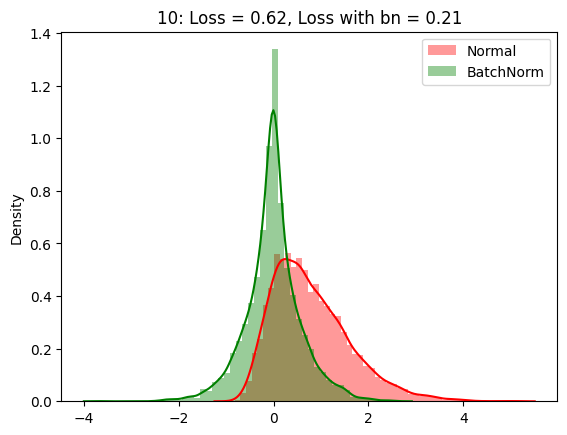

----------------------


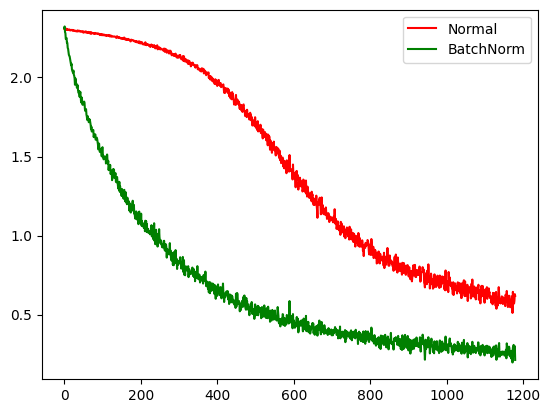

In [38]:
loss_arr = []
loss_bn_arr = []

max_epochs = 10

for epoch in range(max_epochs):

    running_loss = 0.0
    running_loss_bn = 0.0
    for i, data in enumerate(loader, 0):

        inputs, labels = data

        # training steps for normal model
        opt.zero_grad()
        outputs = net_without_batch_norm(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()

        # training steps for bn model
        opt_bn.zero_grad()
        outputs_bn = net_with_batch_norm(inputs)
        loss_bn = loss_fn(outputs_bn, labels)
        loss_bn.backward()
        opt_bn.step()

        loss_arr.append(loss.item())
        loss_bn_arr.append(loss_bn.item())

        # print statistics
        running_loss += loss.item()
        running_loss_bn += loss_bn.item()
        if i % 40 == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f  loss_bn: %.3f'%
                  (epoch + 1, (i + 1)*512, running_loss / 40, running_loss_bn / 40))
            running_loss = 0.0
            running_loss_bn = 0.0
    print("="*40)


print("="*10 + " Epoch {} ".format(epoch+1) + "="*10)
inputs = inputs.view(inputs.size(0), -1)

# Code to get the activations
net_without_batch_norm.eval()
net_with_batch_norm.eval()

a = net_without_batch_norm.classifier[0](inputs)
a = a.detach().numpy().ravel()
sns.distplot(a, kde=True, color='r', label='Normal')

b = net_with_batch_norm.classifier[0](inputs)
b = net_with_batch_norm.classifier[1](b)
b = b.detach().numpy().ravel()
sns.distplot(b, kde=True, color='g', label='BatchNorm')

plt.title('%d: Loss = %0.2f, Loss with bn = %0.2f' % (epoch+1, loss.item(), loss_bn.item()))
plt.legend()
plt.savefig("activation-distribution.png", dpi=100)
plt.show()
plt.pause(0.5)

print('----------------------')

# Plotting the loss curves
plt.plot(loss_arr, 'r', label='Normal')
plt.plot(loss_bn_arr, 'g', label='BatchNorm')
plt.savefig("training-loss.png", dpi=100)
plt.legend()
plt.show()
